# Plot training loss and validation loss
This notebook is designed to plot `training loss` and `validation loss` into a single graph via `Seaborn`.  
`training loss` and `validation loss` are fetched from model training script and `eval_dev_loss.py`.  
You should provide the `csv` file path of `training loss` and `validation loss` to draw the figure.  
(It can be downloaded from `tensorboard`)



In [4]:
import seaborn as sns
import pandas as pd
from scipy.signal import savgol_filter
import fine_tune

## Set file path of `training loss` and `validation loss`
Here you should set csv file path of `training loss` and `validation loss`, which are downloaded from `tensorboard`.

In [18]:
train_loss_csv_path = 'data/fine_tune_experiment/log/AKD_hidden_user_defined_1_42_bert_qnli/run-AKD_hidden_user_defined_1_42_bert_qnli-tag-qnli_train_bert_logits_loss.csv'
val_loss_csv_path = 'data/fine_tune_experiment/log/AKD_hidden_user_defined_1_42_bert_qnli/run-AKD_hidden_user_defined_1_42_bert_qnli-tag-qnli_dev_bert_loss.csv'

In [19]:
# Load log step from config.
# It is used for plot.
log_step = fine_tune.config.StudentConfig.load(
    experiment='PKD_Hidden_user_defined_10_42',
    model='bert',
    task='qnli',
    device_id=0
).log_step
print(log_step)

100


## Load them as `pd.DataFrame`

In [20]:
train_loss = pd.read_csv(train_loss_csv_path)
print(train_loss.head())
print(f'row count of `train_loss`: {len(train_loss.index)}')

      Wall time  Step     Value
0  1.629565e+09   100  2.542229
1  1.629565e+09   200  2.482370
2  1.629565e+09   300  2.743447
3  1.629565e+09   400  2.451739
4  1.629565e+09   500  2.420887
row count of `train_loss`: 327


In [21]:
val_loss = pd.read_csv(val_loss_csv_path)
print(val_loss.head())
print(f'row count of `val_loss`: {len(val_loss.index)}')

      Wall time  Step     Value
0  1.629613e+09     0  2.219685
1  1.629613e+09     1  2.306331
2  1.629613e+09     2  2.260073
3  1.629613e+09     3  2.703416
4  1.629613e+09     4  2.352470
row count of `val_loss`: 353


In [22]:
# If row count dosen't match, truncate to smaller one.
train_row_count = len(train_loss.index)
val_row_count = len(val_loss.index)
if train_row_count > val_row_count:
    # truncate `train_loss`
    train_loss.drop(list(range(val_row_count, train_row_count)), inplace=True)
    print(f'Truncated `train_loss`:\n{train_loss.describe()}')
elif train_row_count < val_row_count:
    val_loss.drop(list(range(train_row_count, val_row_count)), inplace=True)
    print(f'Truncated `val_loss`:\n{val_loss.describe()}')
else:
    print("Don't have to truncate")

Truncated `val_loss`:
          Wall time        Step       Value
count  3.270000e+02  327.000000  327.000000
mean   1.629613e+09  163.000000    0.737659
std    2.074225e-02   94.540996    0.494928
min    1.629613e+09    0.000000    0.124122
25%    1.629613e+09   81.500000    0.427830
50%    1.629613e+09  163.000000    0.574954
75%    1.629613e+09  244.500000    0.893068
max    1.629613e+09  326.000000    2.703416


## Merge two dataframe

In [23]:
# Drop unneccesary columns
train_loss.drop(columns=['Wall time','Step'], inplace=True)
train_loss.rename(columns={'Value':'Distil Loss'}, inplace=True)
val_loss.drop(columns=['Wall time','Step'], inplace=True)
val_loss.rename(columns={'Value':'Distil Loss'}, inplace=True)
print(f'{train_loss=}')
print(f'{val_loss=}')

train_loss=     Distil Loss
0       2.542229
1       2.482370
2       2.743447
3       2.451739
4       2.420887
..           ...
322     0.067899
323     0.035366
324     0.034391
325     0.056043
326     0.025454

[327 rows x 1 columns]
val_loss=     Distil Loss
0       2.219685
1       2.306331
2       2.260073
3       2.703416
4       2.352470
..           ...
322     0.229596
323     0.375351
324     0.353817
325     0.379705
326     0.372995

[327 rows x 1 columns]


In [24]:
# Add a new column for both dataframe
train_loss = train_loss.assign(dataset='Train')
val_loss = val_loss.assign(dataset='Dev')

In [25]:
print(f'train_loss\n{train_loss}')
print(f'val_loss\n{val_loss}')

train_loss
     Distil Loss dataset
0       2.542229   Train
1       2.482370   Train
2       2.743447   Train
3       2.451739   Train
4       2.420887   Train
..           ...     ...
322     0.067899   Train
323     0.035366   Train
324     0.034391   Train
325     0.056043   Train
326     0.025454   Train

[327 rows x 2 columns]
val_loss
     Distil Loss dataset
0       2.219685     Dev
1       2.306331     Dev
2       2.260073     Dev
3       2.703416     Dev
4       2.352470     Dev
..           ...     ...
322     0.229596     Dev
323     0.375351     Dev
324     0.353817     Dev
325     0.379705     Dev
326     0.372995     Dev

[327 rows x 2 columns]


In [26]:
# Assign new `Step` column.
train_loss = train_loss.assign(Step=lambda x: x.index * log_step + log_step)
val_loss = val_loss.assign(Step=lambda x: x.index * log_step + log_step)
print(f'train_loss\n:{train_loss}')
print(f'val_loss\n:{val_loss}')

train_loss
:     Distil Loss dataset   Step
0       2.542229   Train    100
1       2.482370   Train    200
2       2.743447   Train    300
3       2.451739   Train    400
4       2.420887   Train    500
..           ...     ...    ...
322     0.067899   Train  32300
323     0.035366   Train  32400
324     0.034391   Train  32500
325     0.056043   Train  32600
326     0.025454   Train  32700

[327 rows x 3 columns]
val_loss
:     Distil Loss dataset   Step
0       2.219685     Dev    100
1       2.306331     Dev    200
2       2.260073     Dev    300
3       2.703416     Dev    400
4       2.352470     Dev    500
..           ...     ...    ...
322     0.229596     Dev  32300
323     0.375351     Dev  32400
324     0.353817     Dev  32500
325     0.379705     Dev  32600
326     0.372995     Dev  32700

[327 rows x 3 columns]


In [27]:
train_loss['Distil Loss'] = savgol_filter(train_loss['Distil Loss'], 5, 2)
val_loss['Distil Loss'] = savgol_filter(val_loss['Distil Loss'], 5, 2)

In [28]:
# Concate them
summary = pd.concat([train_loss,val_loss], ignore_index=True)
print(summary)

     Distil Loss dataset   Step
0       2.512116   Train    100
1       2.590807   Train    200
2       2.598816   Train    300
3       2.529110   Train    400
4       2.432895   Train    500
..           ...     ...    ...
649     0.301928     Dev  32300
650     0.309641     Dev  32400
651     0.379080     Dev  32500
652     0.389801     Dev  32600
653     0.363736     Dev  32700

[654 rows x 3 columns]


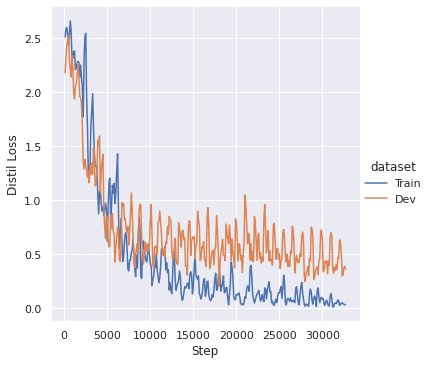

In [29]:
sns.set_theme(style="darkgrid")
sns.relplot(x='Step', y='Distil Loss', kind='line', data=summary, hue='dataset',sort=False)

## (Optional) Save figure as `.png` file

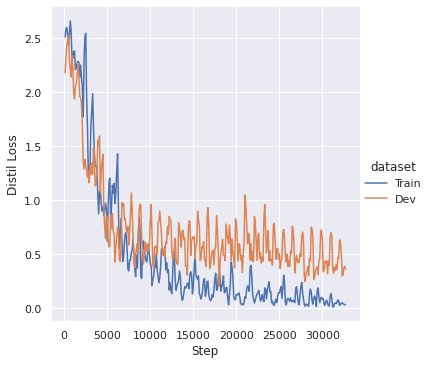

In [30]:
file_name = input("Type in filename:\n")
sns.relplot(x='Step', y='Distil Loss', kind='line', data=summary, hue='dataset',sort=False).savefig(f"{file_name}.png")